In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from SALib.sample import saltelli
from SALib.analyze import sobol

In [2]:

# Load the dataset with chunking
data = xr.open_dataset('pywake_hh_results/FarmFlow.nc', chunks={'time': 100})

# Calculate the mean and variance with chunking
ws_eff_mean = data['WS_eff'].mean(dim='time').compute()
ws_eff_variance = data['WS_eff'].var(dim='time').compute()

x = np.linspace(data.x.min(), data.x.max(), len(data.x))
y = np.linspace(data.y.min(), data.y.max(), len(data.y))

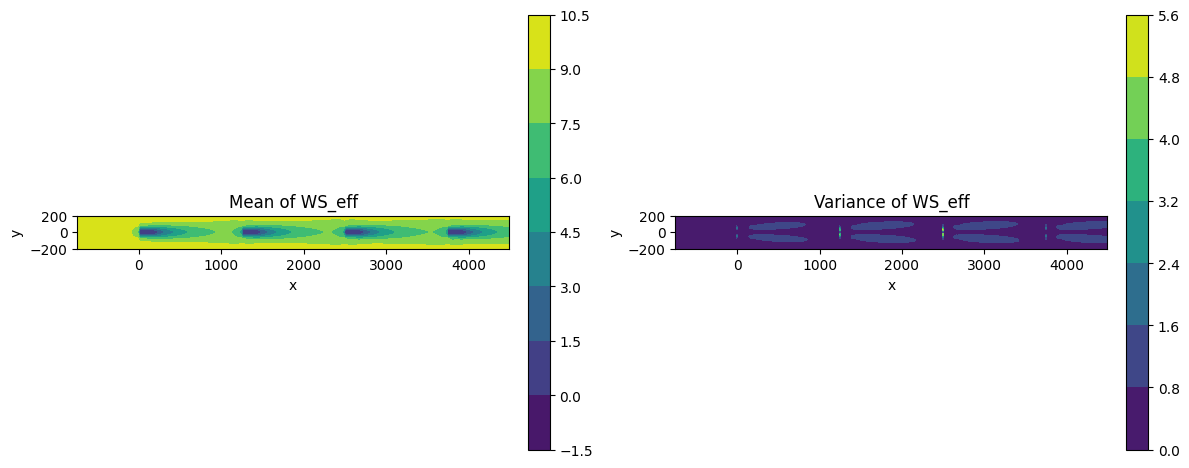

In [3]:

# Create a figure with two subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot mean of WS_eff
c1 = axs[0].contourf(x, y, ws_eff_mean.squeeze())
axs[0].set_title('Mean of WS_eff')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal', adjustable='box')  # Set aspect ratio to 1

# Plot variance of WS_eff
c2 = axs[1].contourf(x, y, ws_eff_variance.squeeze())
axs[1].set_title('Variance of WS_eff')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_aspect('equal', adjustable='box')  # Set aspect ratio to 1

# Adjust colorbar size and position
fig.colorbar(c1, ax=axs[0], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(c2, ax=axs[1], orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

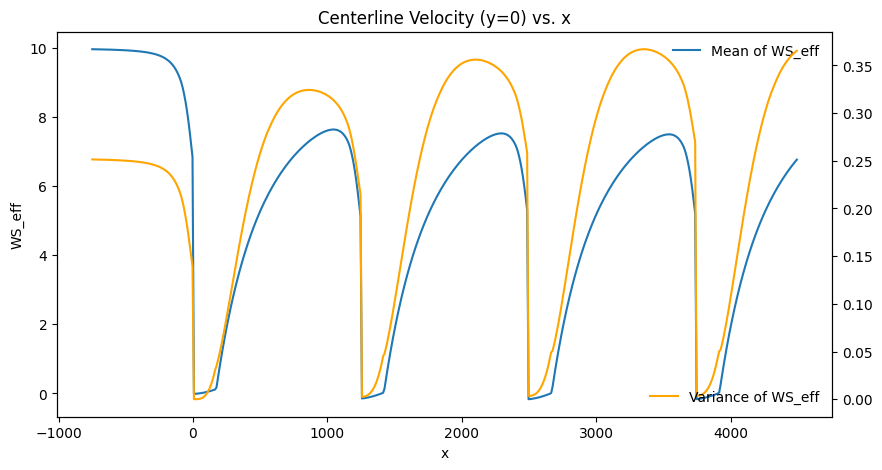

In [4]:
# Extract the centerline (y=0) data
centerline_data = data.sel(y=0, method='nearest')

# Compute the mean and variance along the time dimension for the centerline data
centerline_mean = centerline_data['WS_eff'].mean(dim='time').compute()
centerline_variance = centerline_data['WS_eff'].var(dim='time').compute()

# Create a figure and axis for plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# Plot mean of WS_eff along the centerline
ax.plot(centerline_data['x'], centerline_mean, label='Mean of WS_eff')

# Plot variance of WS_eff along the centerline
ax2 = ax.twinx()
ax2.plot(centerline_data['x'], centerline_variance, label='Variance of WS_eff', c='orange')
ax2.legend(loc='lower right')

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('WS_eff')
ax.set_title('Centerline Velocity (y=0) vs. x')

# Add legend
ax.legend()

plt.show()


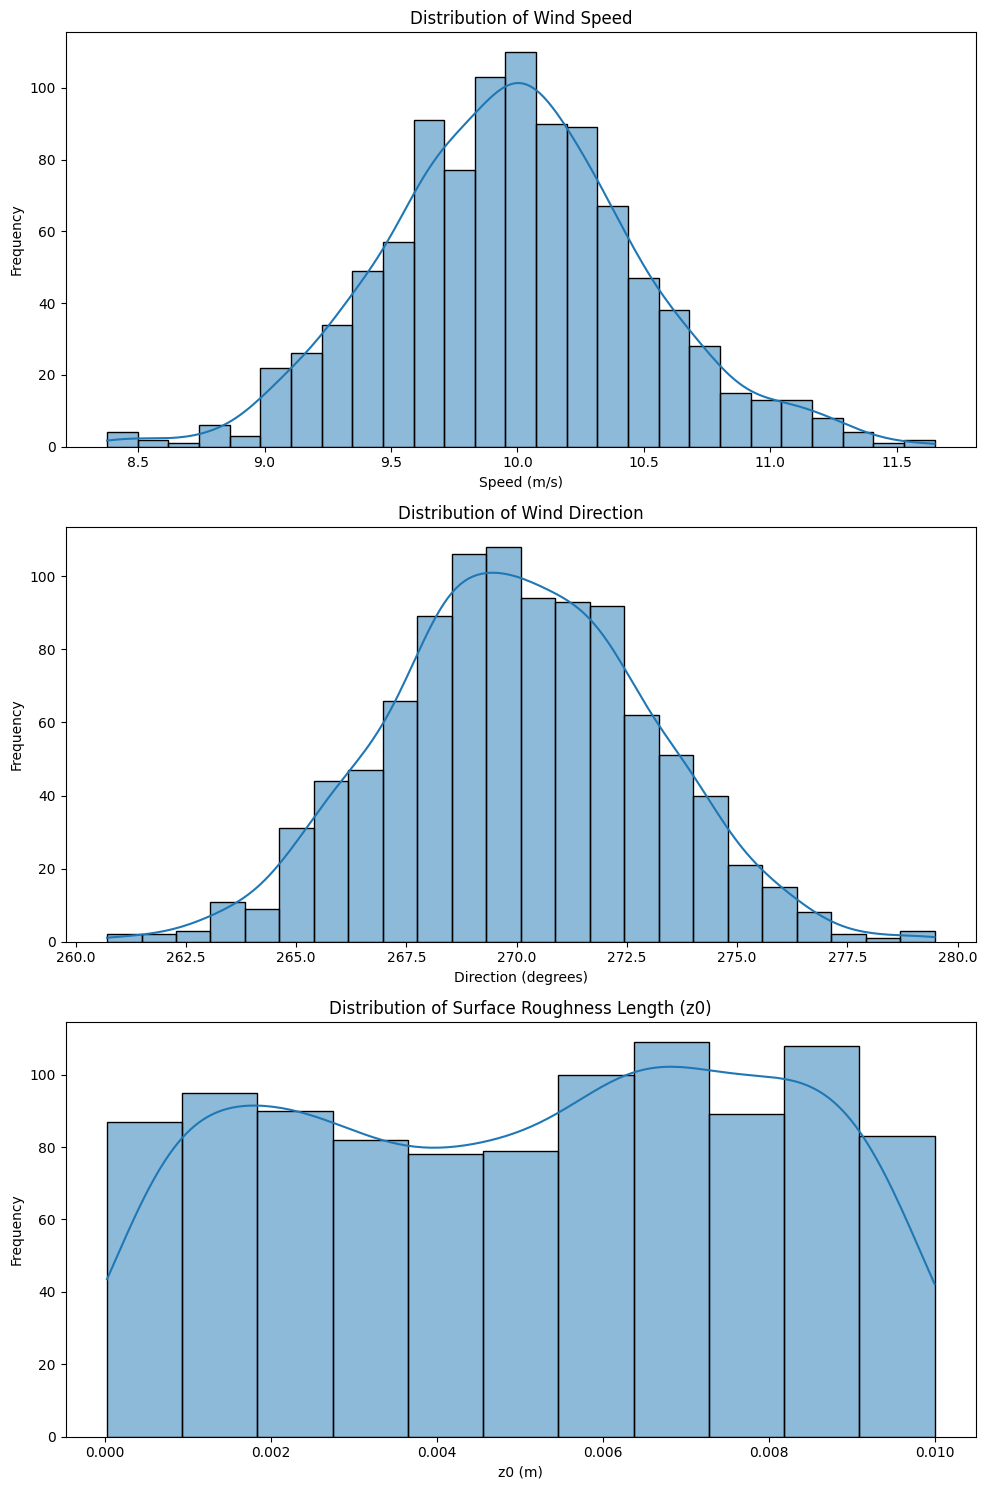

In [5]:

# Load the dataset
inputs = xr.load_dataset('windio_toy/plant_energy_resource/Stochastic_atHubHeight.nc')

# Create a figure with three subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Plot distributions
sns.histplot(inputs['speed'], kde=True, ax=axs[0])
axs[0].set_title('Distribution of Wind Speed')
axs[0].set_xlabel('Speed (m/s)')
axs[0].set_ylabel('Frequency')

sns.histplot(inputs['direction'], kde=True, ax=axs[1])
axs[1].set_title('Distribution of Wind Direction')
axs[1].set_xlabel('Direction (degrees)')
axs[1].set_ylabel('Frequency')

sns.histplot(inputs['z0'], kde=True, ax=axs[2])
axs[2].set_title('Distribution of Surface Roughness Length (z0)')
axs[2].set_xlabel('z0 (m)')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


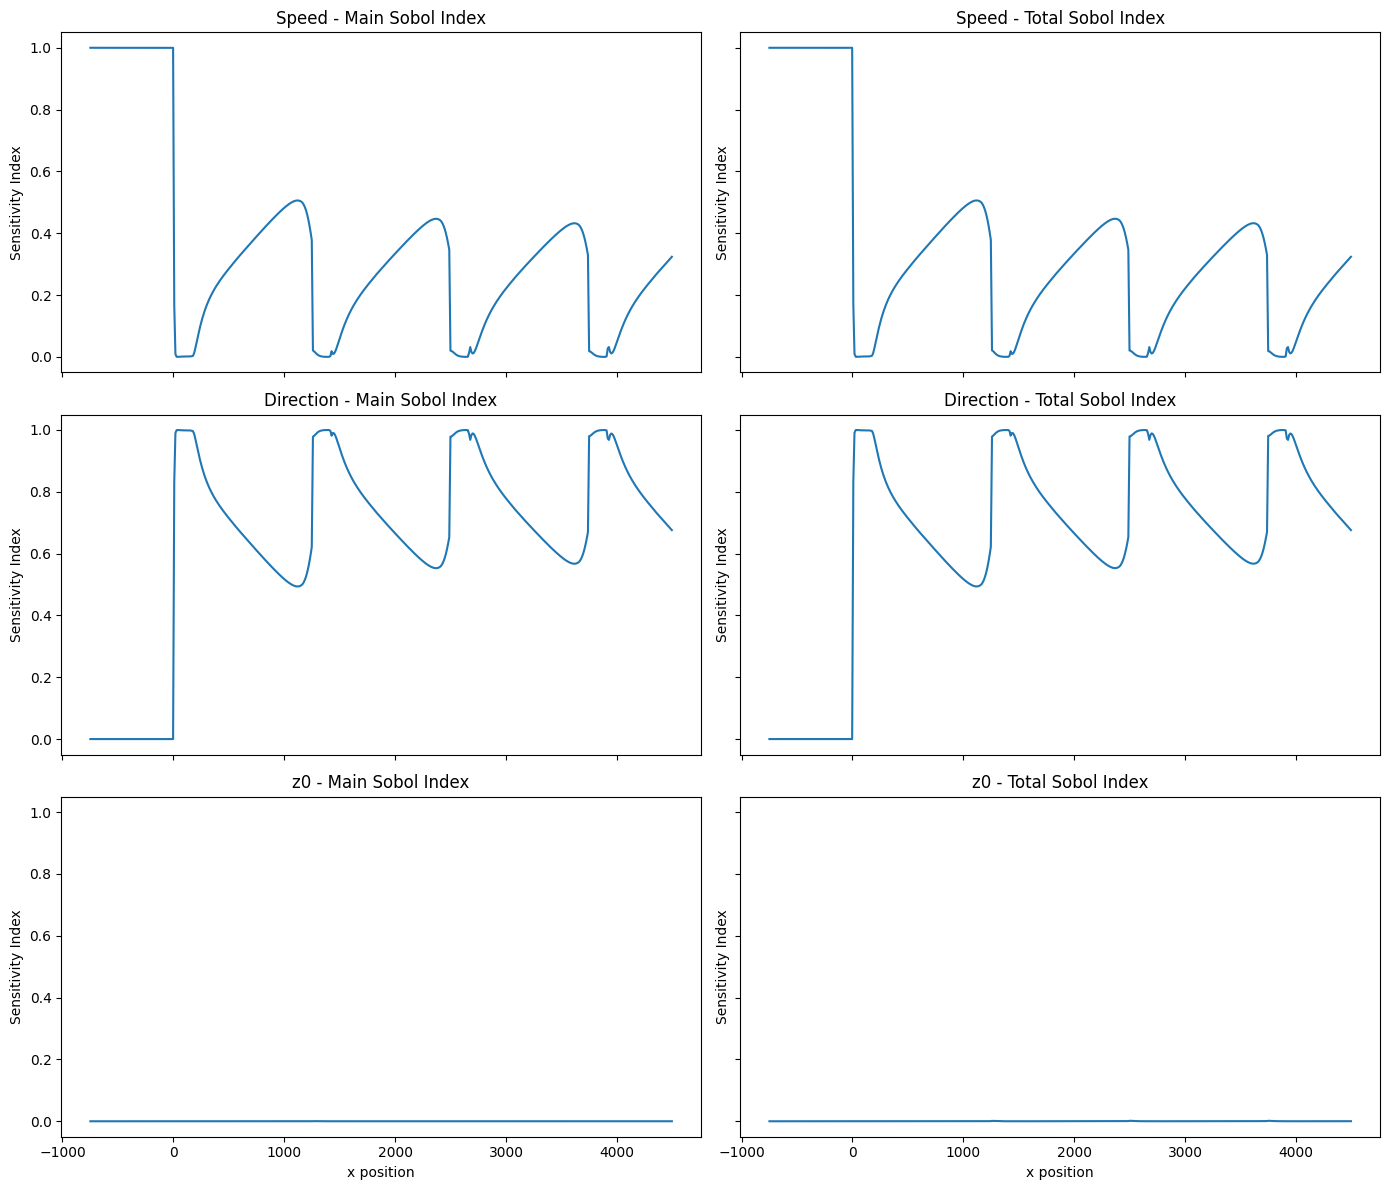

In [6]:
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt

# Load the input data
input_data = xr.load_dataset('windio_toy/plant_energy_resource/Stochastic_atHubHeight.nc')

# Load the output data
output_data = xr.open_dataset('pywake_hh_results/FarmFlow.nc')
centerline_output = output_data.sel(y=0, method='nearest')['WS_eff'].compute()

# Define the distributions for the input parameters
distribution = cp.J(cp.Normal(input_data['speed'].mean(), input_data['speed'].std()),
                    cp.Normal(input_data['direction'].mean(), input_data['direction'].std()),
                    cp.Uniform(input_data['z0'].min(), input_data['z0'].max()))

# Generate abscissas (inputs) and evaluations (outputs)
abscissas = np.column_stack([input_data[key].values for key in ['speed', 'direction', 'z0']])
evals = centerline_output.values

# Generate a polynomial expansion
polynomial_expansion = cp.generate_expansion(2, distribution)

# Fit the polynomial to the model outputs
approx_model = cp.fit_regression(polynomial_expansion, abscissas.T, evals.T)

# Preallocate arrays to hold the Sobol indices for each x position
x_values = centerline_output['x'].values
num_vars = 3
first_order_indices = np.zeros((len(x_values), num_vars))
total_order_indices = np.zeros((len(x_values), num_vars))

# Compute Sobol indices for the approximated model
sobol_indices = cp.Sens_m(approx_model, distribution)
total_sobol_indices = cp.Sens_t(approx_model, distribution)

# Setup subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharex=True, sharey=True)
variables = ['Speed', 'Direction', 'z0']
for i, var in enumerate(variables):
    axs[i, 0].plot(x_values, sobol_indices[i].flatten(), label=f'{var} Main')
    axs[i, 1].plot(x_values, total_sobol_indices[i].flatten(), label=f'{var} Total')

    axs[i, 0].set_title(f'{var} - Main Sobol Index')
    axs[i, 1].set_title(f'{var} - Total Sobol Index')

    axs[i, 0].set_ylabel('Sensitivity Index')
    axs[i, 1].set_ylabel('Sensitivity Index')

# Set common labels
for ax in axs[-1, :]:
    ax.set_xlabel('x position')

# Show the plot
plt.tight_layout()
plt.show()

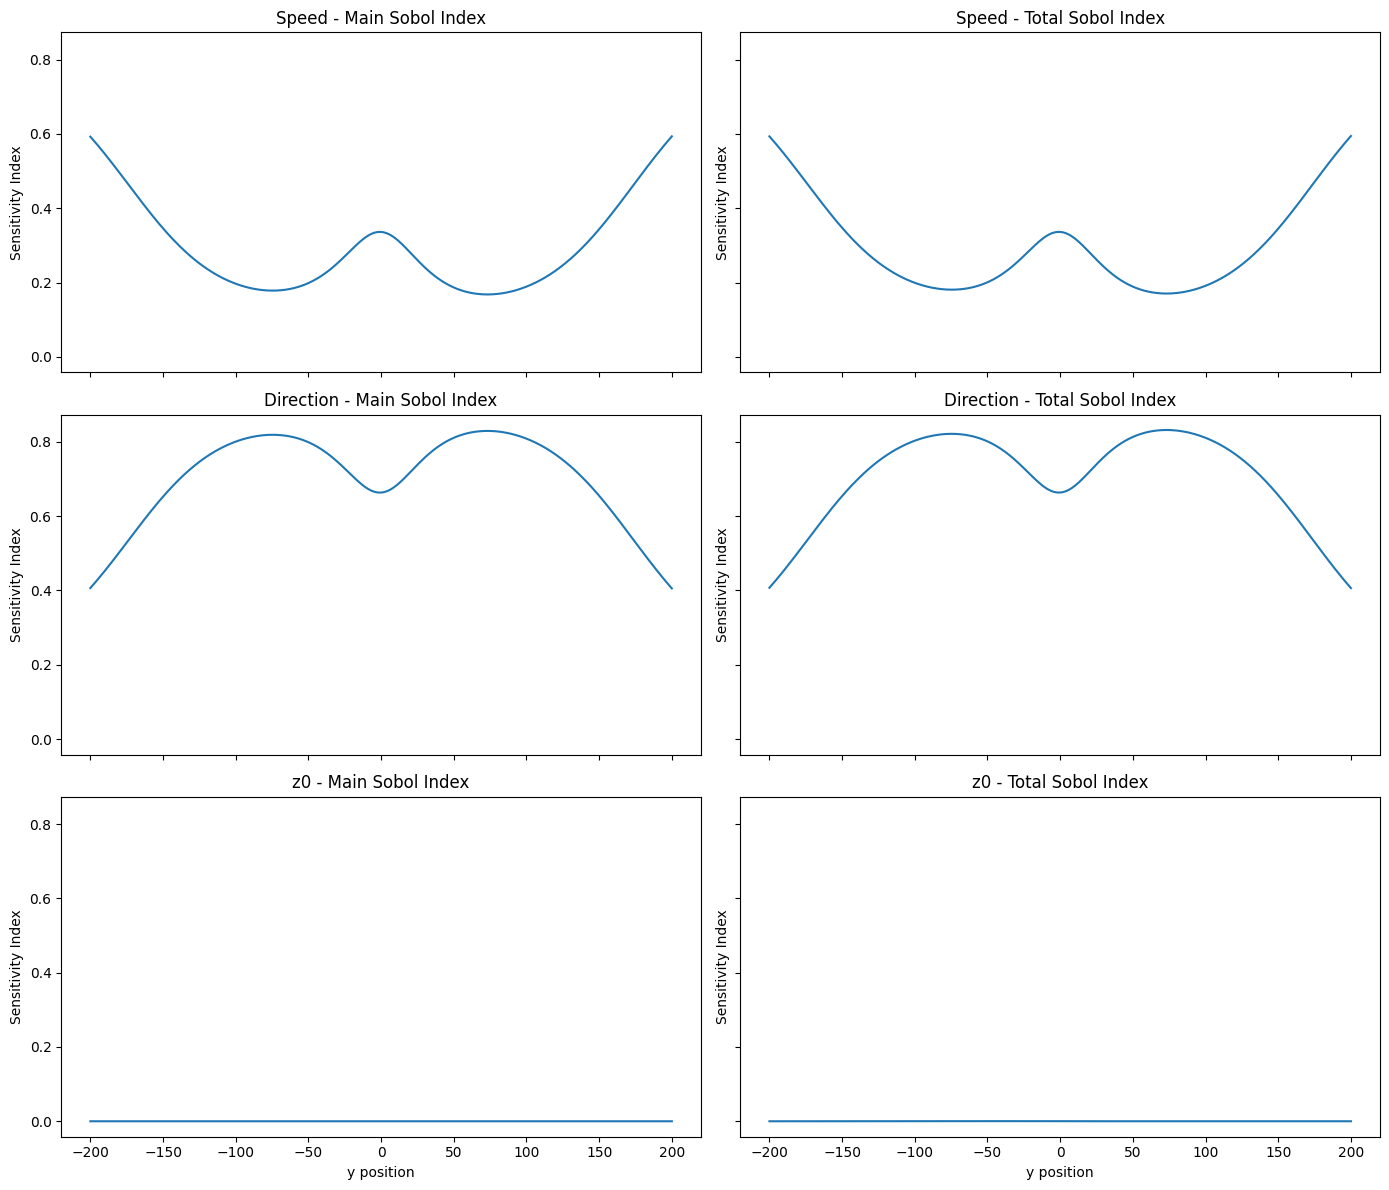

In [14]:
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt

# Load the input data
input_data = xr.load_dataset('windio_toy/plant_energy_resource/Stochastic_atHubHeight.nc')

# Load the output data
output_data = xr.open_dataset('pywake_hh_results/FarmFlow.nc')
centerline_output = output_data.sel(x=2000, method='nearest')['WS_eff'].compute()

# Define the distributions for the input parameters
distribution = cp.J(cp.Normal(input_data['speed'].mean(), input_data['speed'].std()),
                    cp.Normal(input_data['direction'].mean(), input_data['direction'].std()),
                    cp.Uniform(input_data['z0'].min(), input_data['z0'].max()))

# Generate abscissas (inputs) and evaluations (outputs)
abscissas = np.column_stack([input_data[key].values for key in ['speed', 'direction', 'z0']])
evals = centerline_output.values

# Generate a polynomial expansion
polynomial_expansion = cp.generate_expansion(2, distribution)

# Fit the polynomial to the model outputs
approx_model = cp.fit_regression(polynomial_expansion, abscissas.T, evals.T)

# Preallocate arrays to hold the Sobol indices for each x position
y_values = centerline_output['y'].values
num_vars = 3
first_order_indices = np.zeros((len(y_values), num_vars))
total_order_indices = np.zeros((len(y_values), num_vars))

# Compute Sobol indices for the approximated model
sobol_indices = cp.Sens_m(approx_model, distribution)
total_sobol_indices = cp.Sens_t(approx_model, distribution)

# Setup subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharex=True, sharey=True)
variables = ['Speed', 'Direction', 'z0']
for i, var in enumerate(variables):
    axs[i, 0].plot(y_values, sobol_indices[i].flatten(), label=f'{var} Main')
    axs[i, 1].plot(y_values, total_sobol_indices[i].flatten(), label=f'{var} Total')

    axs[i, 0].set_title(f'{var} - Main Sobol Index')
    axs[i, 1].set_title(f'{var} - Total Sobol Index')

    axs[i, 0].set_ylabel('Sensitivity Index')
    axs[i, 1].set_ylabel('Sensitivity Index')

# Set common labels
for ax in axs[-1, :]:
    ax.set_xlabel('y position')

# Show the plot
plt.tight_layout()
plt.show()

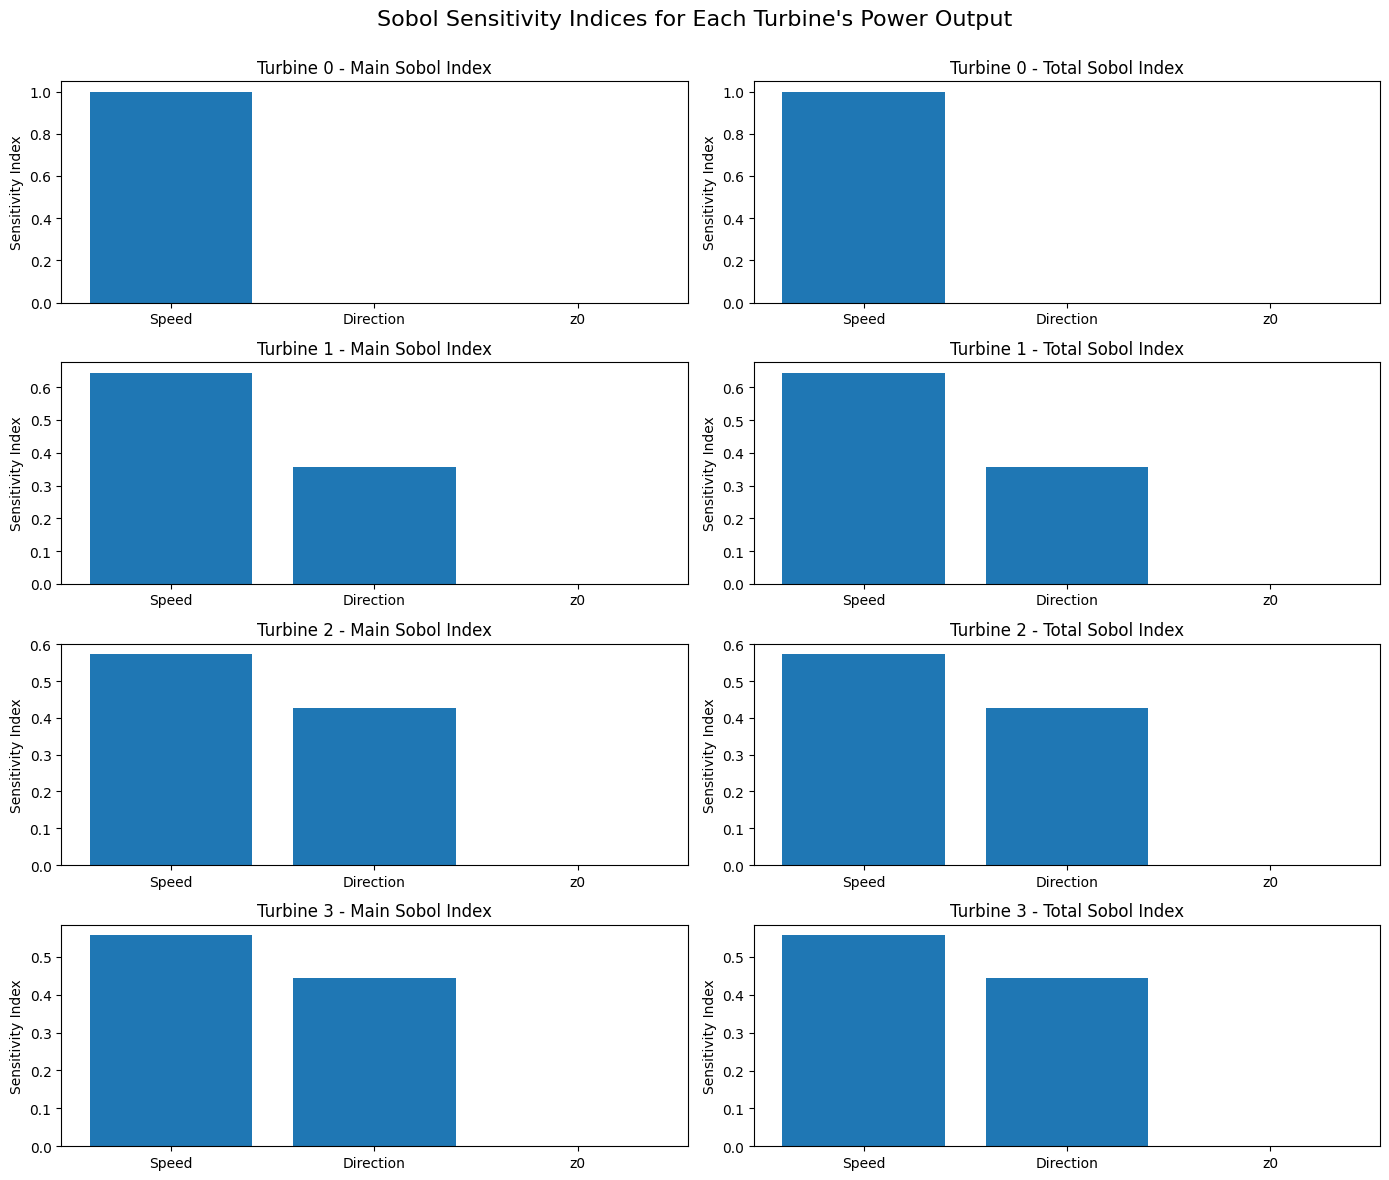

In [8]:
import chaospy as cp
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Load input data
input_data = xr.load_dataset('windio_toy/plant_energy_resource/Stochastic_atHubHeight.nc')

# Load turbine power data
power_data = xr.load_dataset('pywake_hh_results/PowerTable.nc')

# Define the joint probability distribution for the input parameters
distribution = cp.J(cp.Normal(input_data['speed'].mean(), input_data['speed'].std()),
                    cp.Normal(input_data['direction'].mean(), input_data['direction'].std()),
                    cp.Uniform(input_data['z0'].min(), input_data['z0'].max()))

# Generate abscissas (inputs)
abscissas = np.column_stack([input_data[key].values for key in ['speed', 'direction', 'z0']])

# Set up the subplots: one row for each turbine, two columns for main and total indices
num_turbines = len(power_data['wt'])
fig, axs = plt.subplots(num_turbines, 2, figsize=(14, 3 * num_turbines))
fig.suptitle('Sobol Sensitivity Indices for Each Turbine\'s Power Output', fontsize=16)

# Loop through each turbine
for wt_idx, wt in enumerate(power_data['wt'].values):
    # Get power output for the current turbine
    power_output = power_data['Power'].sel(wt=wt).values

    # Fit polynomial to the model outputs
    polynomial_expansion = cp.generate_expansion(2, distribution)
    approx_model = cp.fit_regression(polynomial_expansion, abscissas.T, power_output)

    # Compute Sobol indices
    sobol_indices = cp.Sens_m(approx_model, distribution)
    total_sobol_indices = cp.Sens_t(approx_model, distribution)

    # Plot main sensitivity indices
    axs[wt_idx, 0].bar(['Speed', 'Direction', 'z0'], sobol_indices)
    axs[wt_idx, 0].set_title(f'Turbine {wt} - Main Sobol Index')
    axs[wt_idx, 0].set_ylabel('Sensitivity Index')

    # Plot total sensitivity indices
    axs[wt_idx, 1].bar(['Speed', 'Direction', 'z0'], total_sobol_indices)
    axs[wt_idx, 1].set_title(f'Turbine {wt} - Total Sobol Index')
    axs[wt_idx, 1].set_ylabel('Sensitivity Index')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


/var/folders/5p/nfz1p4ls3q91_7x9ktyf9c7r0000gn/T/ipykernel_33831/4154799549.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 10000)  # Adjust the number of samples for available resources
/Users/julianquick/miniconda3/envs/test/lib/python3.12/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


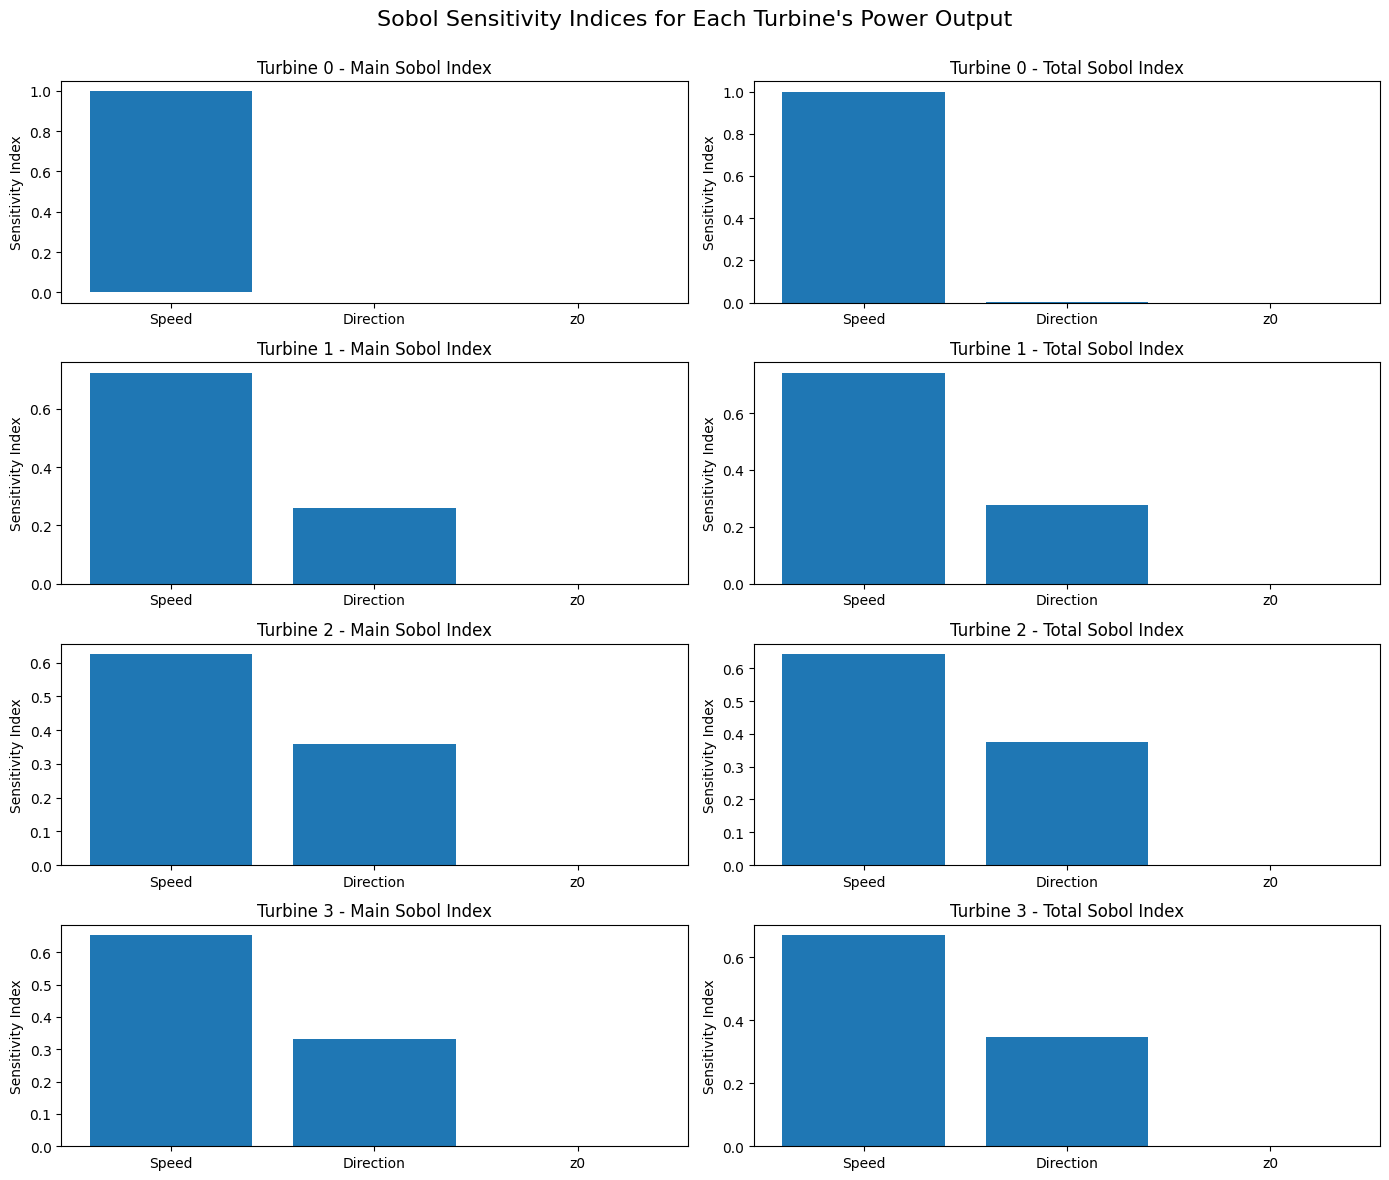

In [9]:
import xarray as xr
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol

# Load input data
input_data = xr.load_dataset('windio_toy/plant_energy_resource/Stochastic_atHubHeight.nc')

# Load turbine power data
power_data = xr.load_dataset('pywake_hh_results/PowerTable.nc')

# Define the problem for the sensitivity analysis
problem = {
    'num_vars': 3,
    'names': ['speed', 'direction', 'z0'],
    'bounds': [[input_data['speed'].min(), input_data['speed'].max()],
               [input_data['direction'].min(), input_data['direction'].max()],
               [input_data['z0'].min(), input_data['z0'].max()]]
}

# Generate Monte Carlo samples
param_values = saltelli.sample(problem, 10000)  # Adjust the number of samples for available resources

# Prepare subplots for each turbine
num_turbines = len(power_data['wt'])
fig, axs = plt.subplots(num_turbines, 2, figsize=(14, 3 * num_turbines))
fig.suptitle('Sobol Sensitivity Indices for Each Turbine\'s Power Output', fontsize=16)

# Loop through each turbine
for wt_idx, wt in enumerate(power_data['wt'].values):
    # Prepare input-output pairs for the current turbine
    power_output = power_data['Power'].sel(wt=wt).values
    abscissas = np.column_stack([input_data[key].values for key in ['speed', 'direction', 'z0']])

    # Train XGBoost Regressor
    model = xgb.XGBRegressor()
    model.fit(abscissas, power_output)

    # Evaluate the model using the generated samples
    Y = model.predict(param_values)

    # Perform Sobol Sensitivity Analysis
    Si = sobol.analyze(problem, Y)

    # Plot main sensitivity indices
    axs[wt_idx, 0].bar(['Speed', 'Direction', 'z0'], Si['S1'])
    axs[wt_idx, 0].set_title(f'Turbine {wt} - Main Sobol Index')
    axs[wt_idx, 0].set_ylabel('Sensitivity Index')

    # Plot total sensitivity indices
    axs[wt_idx, 1].bar(['Speed', 'Direction', 'z0'], Si['ST'])
    axs[wt_idx, 1].set_title(f'Turbine {wt} - Total Sobol Index')
    axs[wt_idx, 1].set_ylabel('Sensitivity Index')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


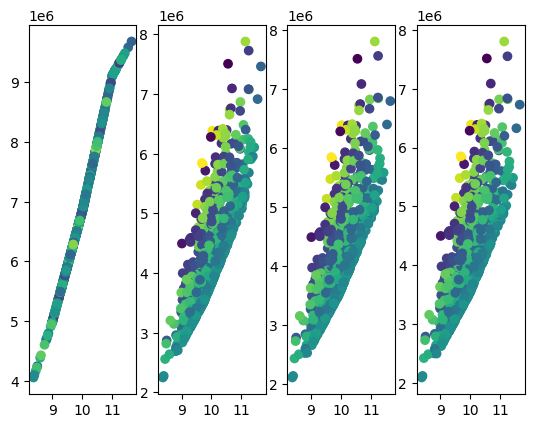

In [11]:
fig, ax = plt.subplots(1, 4)

for ii in range(4):
    subdat = power_data.isel(wt=ii)
    ax[ii].scatter(input_data.speed, subdat.Power, c=input_data.direction)